In [16]:
import numpy as np
import cvxpy as cp
import torch

In [36]:
from scipy.linalg import eigh
from scipy.stats import chi2

In [2]:
from matplotlib import pyplot as plt

### Synthetic Data from Kallus 2018

In [4]:
def toy_policy(X):
    z = X @ beta_e_x
    e_x = np.exp(z) / (1 + np.exp(z))
    return e_x

def zero_policy(X):
    return np.zeros(X.shape[0], dtype=int)

In [3]:
beta0 = 2.5
beta0_t = -2
beta_x = np.asarray([0, .5, -0.5, 0, 0])
beta_x_t = np.asarray([-1.5, 1, -1.5, 1., 0.5])
beta_xi = 1
beta_xi_t = -2
beta_e_x = np.asarray([0, .75, -.5, 0, -1])
mu_x = np.asarray([-1, .5, -1, 0, -1]);

def generate_data(n):
    xi = (np.random.rand(n) > 0.5).astype(int)
    X = mu_x[None, :] + np.random.randn(n * 5).reshape(n, 5)
    eps = [np.random.randn(n) for t in (0, 1)]
    Y = np.array([
        X @ (beta_x + beta_x_t * t) + (beta_xi + beta_xi_t * t) * xi + (beta0 + beta0_t * t) + eps[t]
        for t in (0, 1)
    ])
    U = (Y[0, :] > Y[1, :]).astype(int)
    z = X @ beta_e_x
    e_x = np.exp(z) / (1 + np.exp(z))
    e_xu = (6 * e_x) / (4 + 5 * U + e_x * (2 - 5 * U))
    T = (np.random.rand(n) < e_xu).astype(int)
    Y = Y[T, range(n)]
    return Y, T, X, U, e_x, e_xu

def evaluate_policy(policy, n=1000):
    xi = (np.random.rand(n) > 0.5).astype(int)
    X = mu_x[None, :] + np.random.randn(n * 5).reshape(n, 5)
    eps = [np.random.randn(n) for t in (0, 1)]
    Y = np.array([
        X @ (beta_x + beta_x_t * t) + (beta_xi + beta_xi_t * t) * xi + (beta0 + beta0_t * t) + eps[t]
        for t in (0, 1)
    ])
    e_x = policy(X)
    T = (np.random.rand(n) < e_x).astype(int)
    Y = Y[T, range(n)]
    return Y.mean()

In [5]:
n = 10000
Y, T, X, U, e_x, e_xu = generate_data(n)
p_t = e_x * T + (1 - e_x) * (1 - T)  # p_obs(T|X), e_x:=p(T=1|X)

### Ground Truth

In [6]:
evaluate_policy(toy_policy, n=1000000)

3.868368772551626

### IPW estimator

In [7]:
policy_prob = toy_policy(X) * T + (1 - toy_policy(X)) * (1 - T)
est_ipw = np.mean(policy_prob / p_t * Y)

In [8]:
est_ipw

4.01578792430353

### Implement Confounding Robust Hajek Estimator    

In [17]:
def confoundingRobustHajek(r, T, a, b, return_w=False):
    r_np = r.data.numpy() if isinstance(r, torch.Tensor) else r
    w = np.zeros_like(a)
    for t in set(T):
        r_t = r_np[T == t]
        a_t = a[T == t]
        b_t = b[T == t]
        w[T == t] = hajekLP(r_t, a_t, b_t, r.shape[0])
    if isinstance(r, torch.Tensor):
        est = torch.mean(torch.as_tensor(w) * r)
    else:
        est = np.mean(w * r_np)
    return (est, w) if return_w else est

def hajekLP(r, a, b, n):
    m = r.shape[0]
    w = cp.Variable(m)
    phi = cp.Variable(1)
    constraints = [
        np.zeros(m) <= w,
        0 <= phi,
        a * phi <= w,
        w <= b * phi,
        cp.sum(w) == n
    ]
    objective = cp.Minimize(cp.sum(r * w))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return w.value

In [18]:
def get_a_b(e_x, T, gamma):
    p_t = e_x * T + (1 - e_x) * (1 - T)  # p_obs(t|x)
    a = 1 + 1 / gamma * (1 / p_t - 1)
    b = 1 + gamma * (1 / p_t - 1)
    return a, b

In [19]:
a, b = get_a_b(e_x, T, 1.5)
est, w = confoundingRobustHajek(Y * policy_prob, T, a, b, return_w=True)

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, Use

In [20]:
est

3.734201467394038

In [21]:
differentiable_r = torch.tensor(np.random.randn(T.shape[0]), requires_grad=True)
est, w = confoundingRobustHajek(differentiable_r, T, a, b, return_w=True)

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)
/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, Use

In [22]:
est.backward()

In [23]:
torch.allclose(differentiable_r.grad, torch.as_tensor(w / n))

True

### Implement Confounding Robust Kernel Estimator

In [49]:
def confoundingRobustKernel(r, T, X, a, b, p_t, kernel, lambd, error_tol, return_w=False):
    r_np = r.data.numpy() if isinstance(r, torch.Tensor) else r
    # w = KernelLP(r, T, X, a, b, p_t, kernel, lambd, error_tol)
    w = binaryKernelLP(r, T, X, a, b, p_t, kernel, lambd, error_tol)
    if isinstance(r, torch.Tensor):
        est = torch.mean(torch.as_tensor(w) * r)
    else:
        est = np.mean(w * r_np)
    return (est, w) if return_w else est


def binaryKernelLP(r, T, X, a, b, p_t, kernel, lambd, error_tol):
    # implementation for binary case for fair comparison
    n = r.shape[0]
    TX = np.concatenate([T[:, None], X], axis=1)
    K = kernel(TX, TX)
    S, V = eigh(K, subset_by_index=[max(0, n-200), n-1])
    # define variables
    w = cp.Variable(n)
    phi0 = cp.Variable(1)
    phi1 = cp.Variable(1)
    z = cp.Variable(min(200, n))  # low-rank expression of error
    # warm start variables
    # We can run Hajek LP instead and fit GP here
    p_t_scaled = np.zeros_like(p_t)
    p_t_scaled[T == 0] = p_t[T == 0] * np.mean((1 - T) / p_t)
    p_t_scaled[T == 1] = p_t[T == 1] * np.mean(T / p_t)
    w.value = 1 / p_t_scaled
    phi0.value = 1 / np.mean((1 - T) / p_t, keepdims=True)
    phi1.value = 1 / np.mean(T / p_t, keepdims=True)
    z.value = np.zeros(min(200, n))
    
    M = np.diag(S / (S + lambd)) @ V.T @ np.diag(p_t_scaled)
    u = np.diag(S / (S + lambd)) @ V.T @ np.ones(n)
    
    Cov_z = S - S ** 2 / (S + lambd)
    alpha = 0.01
    z_sq_bound = chi2(df=min(200, n)).ppf(1 - alpha)
    
    constraints = [
        np.zeros(n) <= w,
        0 <= phi0,
        0 <= phi1,
        a * (1 - T) * phi0 + a * T * phi1 <= w,
        w <= b * (1 - T) * phi0 + b * T * phi1,
        #cp.sum(w * (1 - T)) == n,
        #cp.sum(w * T) == n,
        z == M @ w - u,
        # cp.abs(V @ z) <= n * error_tol,
        cp.sum(z ** 2 / Cov_z) <= z_sq_bound,
    ]
    objective = cp.Minimize(cp.sum(r * w))
    problem = cp.Problem(objective, constraints)
    problem.solve(warm_start=True)
    
    return w.value


def KernelLP(r, T, X, a, b, p_t, kernel, lambd, error_tol):
    n = r.shape[0]
    TX = np.concatenate([T[:, None], X], axis=1)
    K = kernel(TX, TX)
    S, V = eigh(K, subset_by_index=[max(0, n-200), n-1])
    # define variables
    w = cp.Variable(n)
    z = cp.Variable(min(200, n))  # low-rank expression of error
    
    M = np.diag(S / (S + lambd)) @ V.T @ np.diag(p_t)
    u = np.diag(S / (S + lambd)) @ V.T @ np.ones(n)
    
    constraints = [
        np.zeros(n) <= w,
        a <= w,
        w <= b,
        cp.sum(w) == 2 * n,  # only meaningful for binary (or categorical) treatment
        z == M @ w - u,
        cp.norm1(V @ z) <= n * error_tol,
    ]
    objective = cp.Minimize(cp.sum(r * w))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return w.value

In [45]:
# select kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF

r = Y * policy_prob
_, w = confoundingRobustHajek(r, T, a, b, return_w=True)
e = w * p_t - 1
TX = np.concatenate([T[:, None], X], axis=1)

kernel = WhiteKernel() + ConstantKernel() * RBF()
model = GaussianProcessRegressor(kernel=kernel).fit(TX[:1000], e[:1000])

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 23 times so far.

  warnings.warn(msg, UserWarning)
/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 24 times so far.

  warnings.warn(msg, U

In [46]:
lambd = model.kernel_.k1.noise_level
kernel = model.kernel_.k2
error_tol = np.mean(np.abs(model.predict(TX) - e))

In [50]:
est, w = confoundingRobustKernel(Y * policy_prob, T, X, a, b, p_t, kernel, lambd, error_tol * 0.4, return_w=True)

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 28 times so far.

  warnings.warn(msg, UserWarning)


In [51]:
est  # without sum-up-to-one constraints

3.9085481823698864

In [47]:
est, w = confoundingRobustKernel(Y * policy_prob, T, X, a, b, p_t, kernel, lambd, error_tol * 0.4, return_w=True)

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 25 times so far.

  warnings.warn(msg, UserWarning)
/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 26 times so far.

  warnings.warn(msg, U

In [48]:
est

3.9173118789122623

In [52]:
est, w = confoundingRobustKernel(Y * policy_prob, T, X, a, b, (e_xx * T + (1 - e_xx) * (1 - T)), kernel, lambd, error_tol * 0.4, return_w=True)

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 29 times so far.

  warnings.warn(msg, UserWarning)


In [53]:
est

3.8763837944690183

In [34]:
est, w = confoundingRobustKernel(Y * policy_prob, T, X, a, b, (e_xx * T + (1 - e_xx) * (1 - T)), kernel, lambd, error_tol * 0.1, return_w=True)

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 16 times so far.

  warnings.warn(msg, UserWarning)
/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 17 times so far.

  warnings.warn(msg, U

In [35]:
est

3.898495623157087

### Compare Policy Improvement Performance

### Estimate Propensity Score (Conditional Density Estimation)
- This requires consistent nominal propensity score (p_obs(t|x))
- For discrete t, just run kernel logistic regression

#### Discrete Case

In [356]:
from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score, make_scorer
# roc_auc_score = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

model = LogisticRegressionCV().fit(X, T)
e_xx = model.predict_proba(X)[:, 1]

np.mean(np.abs(e_xx - e_x))

0.03245225608333301

In [9]:
import optuna
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def objective(trial):
    gamma = trial.suggest_float('gamma', 1e-2, 1e+2, log=True)
    lambd = trial.suggest_float('lambd', 1e-3, 1e+3, log=True)
    model = Pipeline([
        ('kpca', KernelPCA(n_components=100, kernel='rbf', gamma=gamma)),
        ('LogReg', LogisticRegression(C=1/lambd)),
    ])   
    cv_scores = cross_val_score(model, X, y=T, cv=4)
    return cv_scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(func=objective, n_trials=100)

In [332]:
study.best_params

{'gamma': 0.010034979398825772, 'lambd': 0.21459944940837156}

In [10]:
Z = KernelPCA(n_components=200, kernel='rbf', gamma=0.01).fit_transform(X)
model = LogisticRegression(C=5).fit(Z, T)
e_xx = model.predict_proba(Z)[:, 1]

np.mean(np.abs(e_xx - e_x))

0.023502960435053497

In [11]:
np.mean(1 / e_x * T), np.mean(1 / (1 - e_x) * (1 - T)), # both should be 1

(0.9926845079200554, 0.9795193002344411)

In [12]:
np.mean(1 / e_xx * T), np.mean(1 / (1 - e_xx) * (1 - T)), # both should be 1

(0.9978398603769248, 0.9503035986662446)

#### Continuous Case (Maybe on the next notebook)

In [598]:
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional

In [614]:
EPS = 1e-6

def benchmark_bandwidth(bw, T, X, cv=5):
    n = T.shape[0]
    indep_type='c' * X.shape[1]
    dep_type='u'
    split = (np.arange(n) % 5)
    cross_entropy = 0
    for i in range(cv):
        train = (split != i)
        test = (split == i)
        model = KDEMultivariateConditional(T[train, None], X[train, :], dep_type='c', indep_type='c' * X.shape[1], bw=bw)
        cross_entropy += np.mean(model.pdf(T[test, None], X[test, :]) + EPS) / cv
    return cross_entropy

In [615]:
best_scale = 0
best_score = - float('inf')
for scale in [0.1, 0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3, 5]:
    bw = scale * np.concatenate([[Y.std()], X.std(axis=0)]) / Y.shape[0] ** (1 / 7)
    score = benchmark_bandwidth(bw, Y, X)
    if score > best_score:
        best_scale = scale
        best_score = score

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_density.py:527: RuntimeWarning: invalid value encountered in double_scalars
  pdf_est.append(f_yx / f_x)


In [616]:
best_scale, best_score

(0.3, 0.19784318708431387)

In [637]:
bw0 = best_scale * np.concatenate([[Y.std()], X.std(axis=0)]) / Y.shape[0] ** (1 / 7)
model = KDEMultivariateConditional(Y[:, None], X, dep_type='c', indep_type='c' * X.shape[1], bw=bw0)

In [638]:
e_xx = model.pdf(Y[:, None], X)
e_xx

array([1.62958717, 1.62951695, 1.62941804, ..., 1.62956773, 1.62958717,
       1.62958716])

(array([3.000e+00, 5.000e+00, 7.000e+00, 9.000e+00, 2.100e+01, 2.500e+01,
        2.900e+01, 4.700e+01, 1.230e+02, 7.731e+03]),
 array([1.15235734, 1.20008033, 1.24780331, 1.29552629, 1.34324927,
        1.39097226, 1.43869524, 1.48641822, 1.5341412 , 1.58186419,
        1.62958717]),
 <BarContainer object of 10 artists>)

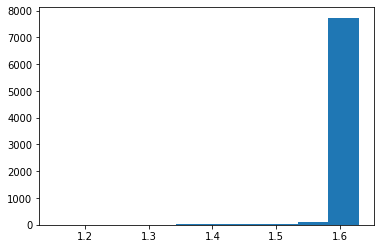

In [639]:
plt.hist(e_xx)

In [640]:
model.bw

array([0.24481187, 0.08247946, 0.08201479, 0.08216818, 0.08203077,
       0.08354723])

In [636]:
[np.mean(1. / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1

[0.0036205488784271846,
 0.005530541824885594,
 0.008353342645354245,
 0.0092354679017507,
 0.008828923218367986,
 0.006834553073471655,
 0.0047634763845408505]

In [650]:
# Shouldn't we use loo estimate for propensity? (For reducing the sampling bias)

In [651]:
model_loocv = KDEMultivariateConditional(Y[:500, None], X[:500], dep_type='c', indep_type='c' * X.shape[1], bw='cv_ml')
model_loocv = KDEMultivariateConditional(Y[:, None], X, dep_type='c', indep_type='c' * X.shape[1], bw=model_loocv.bw)
model_loocv.pdf(T[:, None], X)

array([0.00156597, 0.11336096, 0.18019459, ..., 0.15350272, 0.27772491,
       0.00683612])

In [652]:
model_loocv.bw

array([1.16864112, 0.39784615, 0.47414212, 0.34012805, 0.49598966,
       1.03207938])

In [653]:
e_xx = model_loocv.pdf(Y[:, None], X)
e_xx

array([0.16803556, 0.19643081, 0.13837616, ..., 0.08974823, 0.28981744,
       0.16892645])

In [654]:
[np.mean(1. / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1

[0.42097172629623864,
 0.5610275108978744,
 0.7806948645405306,
 0.8323803841286099,
 0.8266400377542329,
 0.6698018012108039,
 0.4903058358518989]

In [660]:
Y, T, X, U, e_x, e_xu = generate_data(2000)

In [661]:
# Maybe better to use gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF
from scipy.stats import norm

kernel = WhiteKernel() + ConstantKernel() * RBF()
model = GaussianProcessRegressor(kernel=kernel).fit(X, Y)
mu, sigma = model.predict(X, return_std=True)
e_xx = norm.pdf(Y, loc=mu, scale=sigma)

(array([ 76.,  55.,  81.,  93., 115., 140., 171., 221., 272., 776.]),
 array([2.06249815e-07, 2.74513965e-02, 5.49025868e-02, 8.23537771e-02,
        1.09804967e-01, 1.37256158e-01, 1.64707348e-01, 1.92158538e-01,
        2.19609729e-01, 2.47060919e-01, 2.74512109e-01]),
 <BarContainer object of 10 artists>)

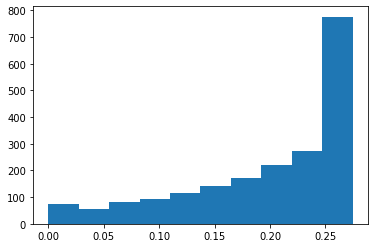

In [662]:
plt.hist(e_xx)

In [663]:
[np.mean(1. / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1

[0.32881986213236836,
 0.7800613489446759,
 1.1082520007466337,
 2425.996762904727,
 2.3731976440293625,
 3.270582402658918,
 1.5545976263818995]